In [12]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Check the first few rows to confirm the data is loaded properly
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [15]:
# Merge the products data with the merged customer and transaction data
merged_df = pd.merge(merged_df, products_df[['ProductID', 'Category']], on='ProductID', how='left')

# Check the first few rows to ensure that the 'Category' column is now in the DataFrame
print(merged_df.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate     Category  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  Electronics  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  Electronics  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  Electronics  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  Electronics  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  Electronics  


In [16]:
# Aggregate transaction data for each customer
customer_profiles = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',          # Total spending
    'Quantity': 'sum',            # Total quantity purchased
    'ProductID': 'nunique',       # Number of unique products purchased
    'Category': lambda x: x.mode()[0] if not x.mode().empty else None,  # Most purchased category
}).reset_index()

# Add additional customer profile features like 'Region' from the 'Customers' dataset
customer_profiles = pd.merge(customer_profiles, customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')

# Check the resulting customer profile DataFrame
print(customer_profiles.head())


  CustomerID  TotalValue  Quantity  ProductID     Category         Region
0      C0001     3354.52        12          5  Electronics  South America
1      C0002     1862.74        10          4     Clothing           Asia
2      C0003     2725.38        14          4   Home Decor  South America
3      C0004     5354.88        23          8        Books  South America
4      C0005     2034.24         7          3  Electronics           Asia


In [17]:
from sklearn.preprocessing import StandardScaler

# Scale the numerical features
scaler = StandardScaler()
customer_profiles[['TotalValue', 'Quantity', 'ProductID']] = scaler.fit_transform(customer_profiles[['TotalValue', 'Quantity', 'ProductID']])

# Check the scaled customer profile DataFrame
print(customer_profiles.head())


  CustomerID  TotalValue  Quantity  ProductID     Category         Region
0      C0001   -0.061701 -0.122033   0.050047  Electronics  South America
1      C0002   -0.877744 -0.448000  -0.424204     Clothing           Asia
2      C0003   -0.405857  0.203934  -0.424204   Home Decor  South America
3      C0004    1.032547  1.670787   1.472798        Books  South America
4      C0005   -0.783929 -0.936951  -0.898455  Electronics           Asia


In [18]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[['TotalValue', 'Quantity', 'ProductID']])

# Check the clusters assigned to each customer
print(customer_profiles[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        3
1      C0002        3
2      C0003        3
3      C0004        4
4      C0005        1


In [19]:
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(customer_profiles[['TotalValue', 'Quantity', 'ProductID']], customer_profiles['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.938455524595955


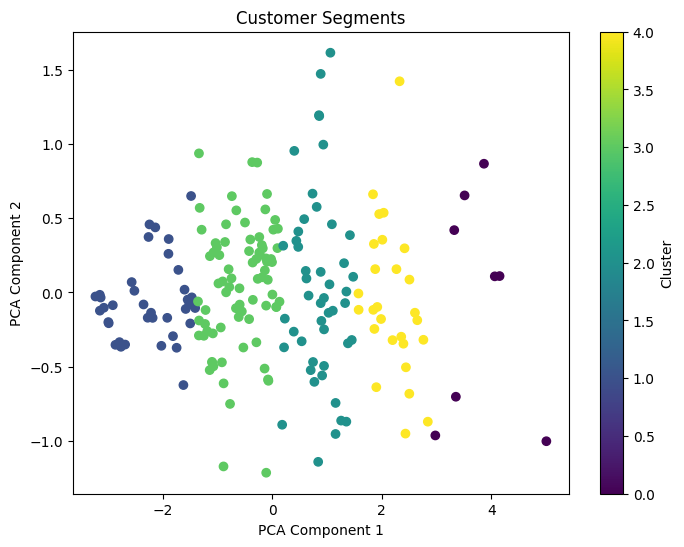

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_profiles[['TotalValue', 'Quantity', 'ProductID']])

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_profiles['Cluster'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [21]:
# Save the customer profiles with clusters to a CSV file
customer_profiles.to_csv('Mirdul_Agrawal_Clustering.csv', index=False)
